### Step 1: Import Packages

In [301]:
import numpy as np 
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn import pipeline
from sklearn.metrics import classification_report,confusion_matrix,f1_score,RocCurveDisplay
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

### Step2: load and check data

In [251]:
data_df = pd.read_csv("bots_trainingdata.csv")

In [252]:
data_df

,Unnamed: 0,userid,twid,lemma,num_tw,bots
0,1,2438710884,563056362608164865,всегда готовый мы же путин с молоко мать приуч...,264,1
1,2,2721957062,562902424437153792,RT почему б немцов не написать на сайт эхо о н...,2257,1
2,3,545362046,562900111970562049,RT путин призывать твердо противостоять попытк...,832,1
3,4,1950819048,562970994047201283,RT путин требовать возвращать отменять электри...,218,1
4,5,2833566787,562970103705534466,RT владимир путин подписывать закон о ратифика...,728,1
...,...,...,...,...,...,...
193322,193323,2346532627,1090949689422299137,RT путин потребовать от васильева следить за у...,2415,1
193323,193324,602150540,1090888970416898048,RT писать что арест арашуков санкционировать л...,6255,1
193324,193325,280865799,1090820483266818048,RT крикливый оппозиция притихать перед они неп...,1562,1
193325,193326,623252874,1091109811687776256,RT путин про украинский церковь спекуляция пол...,6497,1


In [253]:
data_df.isna().sum()

Unnamed: 0     0
userid         0
twid           0
lemma         63
num_tw         0
bots           0
dtype: int64

In [254]:
data.dropna(inplace=True,axis=0)

### Step3: train/test spliting 

In [255]:
X_data = data.drop(["bots"],axis =1)
y_data = data["bots"]

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size =0.3,random_state=42)
X_train

,Unnamed: 0,userid,twid,lemma,num_tw
186649,186650,386438418,1032531742975045632,RT михеев совершенно точно уверенный что как т...,2916
117992,117993,754685830426398720,793395157693526016,Экстренное обращение к учёным всего мира … … #...,22
180790,180791,3351885376,990267496757383169,RT май дом профсоюз он сам загораться так мы с...,987
60355,60356,2931914963,776397663180840960,#сша #украина #крым #рф,549
143360,143361,1419823400,802065644833374208,#ОливерСтоун поверил #Януковичу #Украина #Ша...,649
...,...,...,...,...,...
119926,119927,1610483024,794178459627122688,MailRu Group и Moat сделают российский рекламн...,140
103740,103741,741274201118658560,789046640741060608,Москалькова омбудсмен Украины реагирует #Укра...,728
131979,131980,2901798998,798088098827468800,Развитая финансовая система #США #ЦенныеБумаг...,72
146914,146915,4282038935,804327784403337216,RT упоминать некий страна потерять суверенитет...,1659


### Step4: feature extraction 

In [239]:
## tf-idf feature 
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
xtrain_tfidf =  tfidf_vect.fit_transform(X_train['lemma'])
xtest_tfidf =  tfidf_vect.fit_transform(X_test['lemma'])

## add number of tweets per user as features 
xtrain_tfidf = np.hstack((xtrain_tfidf , np.array(X_train['num_tw'])[:,None].reshape(-1)))
xtrain_tfidf = xtrain_tfidf[0]
xtest_tfidf = np.hstack((xtest_tfidf , np.array(X_test['num_tw'])[:,None].reshape(-1)))
xtest_tfidf = xtest_tfidf[0]


### Step5: model training

In [261]:
from sklearn.linear_model import SGDClassifier

models = [LogisticRegression(solver='lbfgs', max_iter=100),
         DecisionTreeClassifier(),
         #RandomForestClassifier(n_estimators = 100, max_features=3),
         LinearSVC(dual=False,max_iter=100,),
         GradientBoostingClassifier(),
         SGDClassifier(loss='hinge', penalty='l2')]

CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, xtrain_tfidf, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

[Text(0, 0, 'LG'),
 Text(1, 0, 'DTC'),
 Text(2, 0, 'LSVC'),
 Text(3, 0, 'GBC'),
 Text(4, 0, 'SGD')]

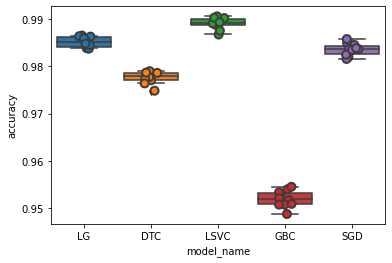

In [262]:
g = sns.boxplot(x='model_name', y='accuracy', data=cv_df)
g = sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
g.set_xticklabels(['LG','DTC','LSVC','GBC','SGD'])

In [268]:
LinearSVC().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

### step6: parameter tuning and fit

In [272]:
SVC_model = LinearSVC()
clf = pipeline.Pipeline([('svc', SVC_model)])


# set parameter
param_grid = {'svc__C': [1, 10, 100], 
              'svc__max_iter': [100,1000],
              'svc__penalty': ['l1','l2']}

# Grid Search Model init
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', n_jobs=-1, refit=True)

# fit grid search model
model.fit(xtrain_tfidf, y_train)
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
xgboost_std_best_parameters = best_parameters


/Users/jarvis/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jarvis/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jarvis/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jarvis/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py", line 257, in fit
    self.coef

Best score: 0.989
Best parameters set:
	svc__C: 1
	svc__max_iter: 100
	svc__penalty: 'l2'


In [273]:
model = LinearSVC(dual=False,max_iter=100,C=1,penalty='l2')
model.fit(xtrain_tfidf, y_train)
y_pred = model.predict(xtest_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.66      0.62     27785
           1       0.65      0.59      0.62     30195

    accuracy                           0.62     57980
   macro avg       0.62      0.62      0.62     57980
weighted avg       0.63      0.62      0.62     57980



The accuracy on training data is .99 but on testing data is .62, suggest an overfitting problem. I will use this result as benchmark and train on BERT-deep learning model latter this week. 

In [283]:
train = pd.read_csv("bots_testing.csv")

In [284]:
train

,Unnamed: 0,userid,twid,date,lemma,num_tw
0,1,361219865,164056320016781312,2012-01-30,#Владимир #Путин #Приморский край Федерация пр...,160
1,2,348949045,164054357061537792,2012-01-30,#Владимир #Путин #Москва Путин Take A Look Ar...,7
2,3,361973430,163934516925317120,2012-01-30,#владимир #россия Нтаталия 27 Женщина есть жен...,20336
3,4,209135296,163930884087615488,2012-01-30,Во #Владимир опять рвутся трубы две аварии в п...,10
4,5,310798465,163886075826274304,2012-01-30,Во Владимирской области прокуратура выявила ма...,302
...,...,...,...,...,...,...
599783,599784,394778880,780066326647681024,2016-09-25,#ua #news Полиция открыла производство по трем...,5908
599784,599785,394778880,780066325540409344,2016-09-25,#ua #news Убито иорданского писателя обвиняемо...,5908
599785,599786,998220474,780066044593307648,2016-09-25,#Экономика #Украина Расходы на стипендии увели...,1707
599786,599787,1841111274,780066041980334080,2016-09-25,#Украина Расходы на стипендии увеличили на бол...,8308


In [280]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
xtrain_tfidf =  tfidf_vect.fit_transform(train['lemma'])

## add number of tweets per user as features 
xtrain_tfidf = np.hstack((xtrain_tfidf , np.array(train['num_tw'])[:,None].reshape(-1)))
xtrain_tfidf = xtrain_tfidf[0]


In [286]:
y_pred = model.predict(xtrain_tfidf)

In [291]:
y_pred = pd.DataFrame(y_pred)

In [292]:
## write out predicting results 
y_pred.to_csv('classification_result.csv',index = False, header=True)